# Filtración colaborativa

importar librerías

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from sklearn.model_selection import train_test_split

Cargar datos

In [2]:
data = pd.read_csv('users_ratings_books.csv')
data.head()

,Unnamed: 0,User-ID,Location,Age,RealCountry,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0,2,"stockton, california, usa",18.0,usa,0195153448,0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,1,10,"albacete, wisconsin, spain",26.0,spain,1841721522,0,New Vegetarian: Bold and Beautiful Recipes for...,Celia Brooks Brown,2001,Ryland Peters &amp; Small Ltd
2,2,3675,"barcelona, catalunya, spain",24.0,spain,1841721522,0,New Vegetarian: Bold and Beautiful Recipes for...,Celia Brooks Brown,2001,Ryland Peters &amp; Small Ltd
3,3,6366,"madrid, madrid, spain",20.0,spain,1841721522,7,New Vegetarian: Bold and Beautiful Recipes for...,Celia Brooks Brown,2001,Ryland Peters &amp; Small Ltd
4,4,13872,"barcelona, catalunya, spain",17.0,spain,1841721522,0,New Vegetarian: Bold and Beautiful Recipes for...,Celia Brooks Brown,2001,Ryland Peters &amp; Small Ltd


In [3]:
data = data.sample(n=50000)
data.head()

,Unnamed: 0,User-ID,Location,Age,RealCountry,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
255460,255460,235842,"griswold, iowa, usa",41.0,usa,1556611536,0,"Julia's Last Hope (Oke, Janette, Women of the ...",Janette Oke,1990,Bethany House Publishers
702489,702489,278720,"wiesloch, baden-württemberg, germany",31.0,germany,0192818252,7,Orlando,Virginia Woolf,1992,Oxford University Press
539652,539652,245371,"halifax, nova scotia, canada",26.0,canada,0375709258,0,Lust &amp; Other Stories (Vintage Contemporaries),Susan Minot,2000,Vintage Books USA
388204,388204,278144,"storm lake, iowa, usa",48.0,usa,0399150803,0,Trojan Odyssey,Clive Cussler,2003,G. P. Putnam's Sons
558522,558522,170229,"chicago, illinois, usa",56.0,usa,0679731180,0,The Origin of Satan,Elaine Pagels,1996,Vintage Books USA


In [4]:
data = data[['User-ID', 'ISBN', 'Book-Rating', 'Book-Author']]



In [20]:
data['User-ID'] = data['User-ID'].astype('category')
data['ISBN'] = data['ISBN'].astype('category')
data['Book-Author'] = data['Book-Author'].astype('category')

In [21]:
data['User-ID'] = data['User-ID'].cat.codes
data['ISBN'] = data['ISBN'].cat.codes
data['Book-Author'] = data['Book-Author'].cat.codes


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 255460 to 183318
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   User-ID      50000 non-null  int16
 1   ISBN         50000 non-null  int32
 2   Book-Rating  50000 non-null  int64
 3   Book-Author  50000 non-null  int16
dtypes: int16(2), int32(1), int64(1)
memory usage: 1.1 MB


In [23]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [24]:

# Definir la arquitectura de la red neuronal
user_input = Input(shape=(1,))
book_input = Input(shape=(1,))
author_input = Input(shape=(1,))

user_embedding = Embedding(input_dim=data['User-ID'].nunique(), output_dim=50)(user_input)
book_embedding = Embedding(input_dim=data['ISBN'].nunique(), output_dim=50)(book_input)
author_embedding = Embedding(input_dim=data['Book-Author'].nunique(), output_dim=50)(author_input)

user_flat = Flatten()(user_embedding)
book_flat = Flatten()(book_embedding)
author_flat = Flatten()(author_embedding)

concat = Concatenate()([user_flat, book_flat, author_flat])

dense1 = Dense(256, activation='relu')(concat)
dense2 = Dense(128, activation='relu')(dense1)
output = Dense(1)(dense2)


In [25]:

# Dividir los datos en conjuntos de entrenamiento y prueba

model = tf.keras.Model(inputs=[user_input, book_input, author_input], outputs=output)

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit([train['User-ID'], train['ISBN'], train['Book-Author']], train['Book-Rating'], epochs=10, batch_size=64)
loss = model.evaluate([test['User-ID'], test['ISBN'], test['Book-Author']], test['Book-Rating'])

print(f'RMSE en el conjunto de prueba: {loss**0.5}')

Epoch 1/10
625/625 [==============================] - 30s 46ms/step - loss: 13.2498
Epoch 2/10
625/625 [==============================] - 31s 50ms/step - loss: 7.5529
Epoch 3/10
625/625 [==============================] - 32s 51ms/step - loss: 3.6432
Epoch 4/10
625/625 [==============================] - 35s 56ms/step - loss: 2.3802
Epoch 5/10
625/625 [==============================] - 34s 55ms/step - loss: 1.7278
Epoch 6/10
625/625 [==============================] - 33s 53ms/step - loss: 1.2563
Epoch 7/10
625/625 [==============================] - 32s 51ms/step - loss: 0.9126
Epoch 8/10
625/625 [==============================] - 31s 50ms/step - loss: 0.6436
Epoch 9/10
625/625 [==============================] - 32s 51ms/step - loss: 0.4647
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 17.2742
RMSE en el conjunto de prueba: 4.1562217768807965


In [26]:
import matplotlib.pyplot as plt

Minimum MSE:  0.3460448384284973


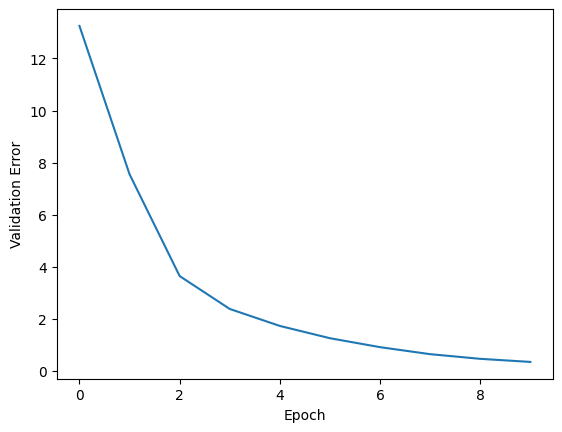

In [27]:
pd.Series(history.history['loss']).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['loss']))